In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant 
from scipy.stats import probplot
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import jarque_bera

In [3]:
def dfSplitter(df):
    y=df['count']
    X=df.iloc[:, :10]
    xTrain, xTest, yTrain, yTest=train_test_split(X, y, train_size=0.8, random_state=42)
    return(xTrain, xTest, yTrain, yTest)

In [4]:
def cleanerX(X1):
    '''
    Add 4 columns into data frame: month, day, hour and name of day 
    '''
    X=X1.copy()
    X['month']=X.index.month
    X['day']=X.index.weekday
    X['hour']=X.index.hour
    X['dayName']=X.index.day_name()
    return X

In [5]:
def featEng(X):
    '''
    Creates new features based on EDA and feature selection to optimize model
    '''
    X['mJun']=np.abs(X['month']-6) 
    X['mJul']=np.abs(X['month']-7)
    X['8h']=np.abs(X['hour']-8)
    X['18h']=np.abs(X['hour']-18)
    X['mJulHol']=X['mJul']*X['holiday']
    X['mJunWD']=X['mJun']*X['workingday']
    X['mJultemp']=X['mJul']*X['temp']
    X['mJulHum']=X['mJul']*X['humidity']
    return(X)

In [6]:
def featEng2(X,y):
    '''
    Cleans up the data for modeling 
    '''
    X.drop(['dayName', 'casual', 'registered'], axis=1, inplace=True)
    y=np.log1p(y+1)
    return(X,y)

In [38]:
def testMod(X, y, xIndex, modName, modType):
    '''
    Uses different models to calculate predicted bike rental count and compares their RMSLE.
    '''
    r2List=[]
    rmsleList=[]
    
    plt.figure(figsize=(10,5))
    sns.lineplot(x=X.index.month, y=y, label='y True')
    for i in range(len(xIndex)):
        if modType=='LR':
            m=LinearRegression()
        elif modType=='DT':
            m=DecisionTreeRegressor()
        elif modType=='RF':
            m=RandomForestRegressor()
        X1=X[xIndex[i]] 
        m.fit(X1, y)
        r2=m.score(X1,y)
        r2List.append(r2)
        X['ypred']=m.predict(X1)
        sns.lineplot(x=X.index.month, y=X['ypred'], label=modName[i])
        rmsle=np.sqrt(mean_squared_log_error(y, X['ypred']))
        rmsleList.append(rmsle)
    plt.xlabel('months')
    plt.ylabel('count')
    plt.legend(loc='lower right')
    plt.show()
    r2Table=pd.DataFrame({'model':modName, '$r^2$':r2List, 'RMSLE':rmsleList})
    display(r2Table)

In [21]:
bikes=pd.read_csv('train.csv', index_col=0, parse_dates=True)

In [22]:
xTrain, xTest, yTrain, yTest=dfSplitter(bikes)

In [23]:
xTrain=cleanerX(xTrain)

In [24]:
xTrain=featEng(xTrain)

In [25]:
xTrain, yTrain=featEng2(xTrain, yTrain)

In [26]:
basic=['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
        'humidity', 'windspeed', 'month', 'day', 'hour']
edaList=['hour', 'atemp','humidity','month','workingday','holiday']
feList=['mJulHol','mJunWD','mJultemp','mJulHum', '8h', '18h']
xIndex=[basic, edaList, feList, edaList+feList, basic+edaList+feList]
modName=['noAnalysis', 'EDA', 'Interact', 'EDA+Interact', 'noAnalysis+EDA+Interact']

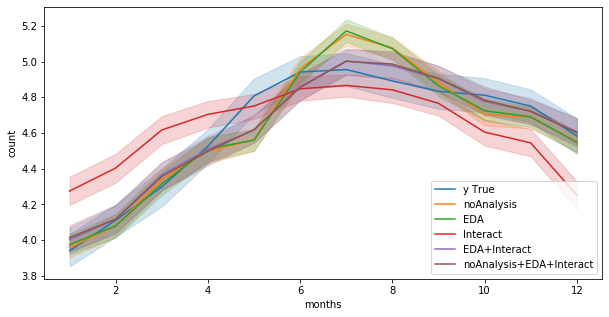

,model,$r^2$,RMSLE
0,noAnalysis,0.465875,0.214645
1,EDA,0.465202,0.214758
2,Interact,0.589365,0.199091
3,EDA+Interact,0.623847,0.192035
4,noAnalysis+EDA+Interact,0.628750,0.191273


In [39]:
testMod(xTrain, yTrain, xIndex, modName, 'LR')

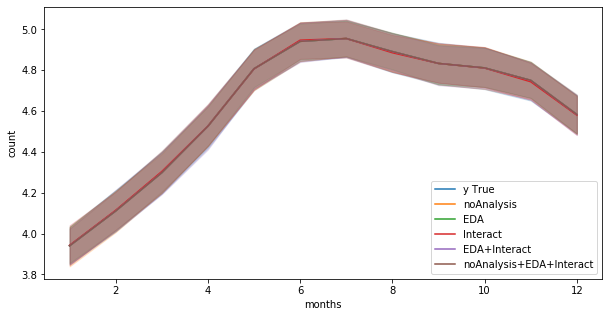

,model,$r^2$,RMSLE
0,noAnalysis,0.999994,0.000798
1,EDA,0.996537,0.016826
2,Interact,0.989819,0.030208
3,EDA+Interact,0.997199,0.015301
4,noAnalysis+EDA+Interact,0.999994,0.000798


In [40]:
testMod(xTrain, yTrain, xIndex, modName, 'DT')

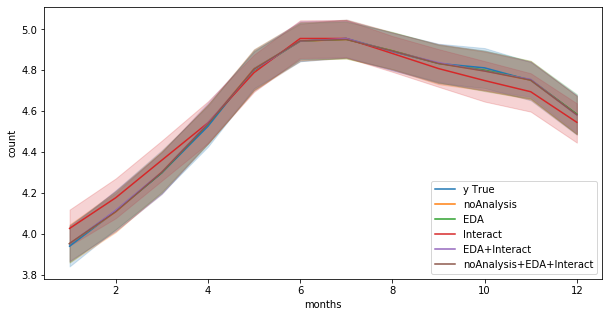

,model,$r^2$,RMSLE
0,noAnalysis,0.990523,0.031153
1,EDA,0.986004,0.036825
2,Interact,0.974756,0.048582
3,EDA+Interact,0.986663,0.036105
4,noAnalysis+EDA+Interact,0.990492,0.031448


In [41]:
testMod(xTrain, yTrain, xIndex, modName, 'RF')